## Image classification with Convolutional Neural Networks using Keras

In [1]:
# Check if gpu is used (optional)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16486440065140094492
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17349414577268647750
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4499022217534744512
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D 

2.3.1


In [3]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

## Loading the data

In the code below, the MNIST data is loaded and the features are rescaled. In this case we don't need a trainable scaler since the features are pixel values, i.e., integers between 0 and 155. We rescale them to be in [0,1] since this seems to work better with many neural network architectures.

There already is a predefined test set, but we split off a validation set (from the training data) of 10000 samples.

In [4]:
# load train and test data
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()


In [5]:
# let's print the shape before we reshape and normalize
print("X_train_all shape", X_train_all.shape)
print("y_train_all shape", y_train_all.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)


X_train_all shape (60000, 28, 28)
y_train_all shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


### Data Preparation
* MNIST dataset **requires some preparation** for use in a convnet

#### Reshaping the Image Data 
* **Convnets** require **NumPy array inputs** 
* Each **sample** must have the **shape**
> (**width**, **height**, **channels**)
* Each pixel has **one channel** (grayscale shade 0-255), so sample shapes will be 
> **`(28, 28, 1)`**
* As the **neural network learns** from the images, it **creates many more channels**
    * These channels will **represent more complex features**, like **edges**, **curves** and **lines**
    * Enable network to **recognize digits** based on these features and how they’re **combined**  
  
* NumPy array method `reshape` receives a tuple representing the new shape

In [6]:
X_train_all = X_train_all.reshape((60000, 28, 28, 1))
print(X_train_all.shape)

X_test = X_test.reshape((10000, 28, 28, 1))
print(X_test.shape)

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
# normalized data leads to better models
X_train_all = X_train_all.astype('float32')
X_test = X_test.astype('float32')
X_train_all /= 255
X_test /= 255

# print the final input shape 
print("Train_all matrix shape", X_train_all.shape)
print("Test matrix shape", X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
Train_all matrix shape (60000, 28, 28, 1)
Test matrix shape (10000, 28, 28, 1)


In [7]:
# This data set contains a training set and a test set
# we still need to split off a validation set

# Number of test samples
N_test = X_test.shape[0]

# split off 10000 samples for validation
N_val = 10000
N_train = X_train_all.shape[0] - N_val

# now extract the samples into train, validate and test sets
# set random state = 0 to make sure you get the same split each time
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size = N_val, random_state=0)


From the documentation of `train_test_split`:

>*test_size: float or int, default=None* 

>If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size (which is also a parameter). If train_size is also None, it will be set to 0.25.

## Multi-class classification

For multi-class classification problems with k classes, we train one model output per class. Each of the k outputs represents the probability that the sample comes from that class. This means the target labels are vectors of k values, all of which are zero except for that which corresponds to the correct class.

There are multiple ways to achieve this. Here, we will convert class vectors to binary class matrices instead of 1 integer label, you now have 10 binary labels (1 for each class) these labels represent the desired class probabilities: all labels are zero, except the one for the right class, which is one.

This will result in a model that outputs vectors of 10 probabilities when calling its 'predict()' function. In the analysis notebook, we will obtain class labels by finding the largest probability.

In [8]:
y_train_all = keras.utils.to_categorical(y_train_all)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

# look at the new labels for the first sample
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


For classification, the output layer ends in a sigmoid activation. However, for multiple classes, it needs to be ensured that the outputs sum up to 1 (since they represent class probabilities). This is achieved with the 'softmax' activation function.

Since we are addressing a multi-class classification problem, with vectors of zeros and ones as labels, the loss function is 'categorical cross entropy'. 


In [9]:
num_classes = 10

# A typical convnet consists of
# input layer that receives training samples
# hidden layers that learn from training samples
# output layer that produces predictions

def initial_model():
    # we create a variable called model, and we set it equal to an instance of a Sequential object.
    model = Sequential()

    # We'll start with a convolution layer
    # A convolutional layer uses the relationships between pixels in close proximity to learn useful features (or patterns) in small areas of each sample
    # These features become inputs to subsequent layers
    # Kernels typically are 3-by-3 (or 5-by-5 or 7-by-7) 
    # Kernel-size is a hyperparameter
    # By looking at features near one another, the network begins to recognize features, like edges, straight lines and curves
    # Next, convolution layer moves kernel one pixel to the right (the stride)
    # Complete pass left-to-right and top-to-bottom is called a filter
    # For a 3-by-3 kernel, the filter dimensions will be two less than the input dimensions
    # For each 28-by-28 MNIST image, the filter will be 26-by-26
    # Number of filters in the convolutional layer is commonly 32 or 64 for small images

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

    # Input samples are 28-by-28-by-1—that is, 784 features each
    # Specified 64 filters and a 3-by-3 kernel for the layer, so the feature map size is 26-by-26-by-64 for a total of 26x26x64=43.264 features

    # Adding a pooling layer
    # Outputs maximum feature from each pool
    # Stride for a 2-by-2 pool is 2
    # Every group of four features is reduced to one, so 2-by-2 pooling compresses number of features by 75%
    # Reduces previous layer’s output from 26-by-26-by-64 to 13-by-13-by-64  
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    # Convnets often have many convolution and pooling layers.
    # Input to the second convolution layer is the 13-by-13-by-64 output of the first pooling layer
    # Output of this Conv2D layer will be 11-by-11-by-128
    # For odd dimensions like 11-by-11, Keras pooling layers round down by default (in this case to 10-by-10), so this pooling layer’s output will be 5-by-5-by-128

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Flattening the results
    # Model's final output will be a one-dimensional array of 10 probabilities that classify the digits
    # To prepare for one-dimensional final predictions, need to flatten the previous layer’s output to one dimension
    # Flatten layer's output will be 1-by-3200 (5 × 5 × 128)

    model.add(Flatten())

    # Adding a Dense Layer to Reduce the Number of Features
    # Layers before the Flatten layer learned digit features
    # Now must learn the relationships among those features to classify which digit each image represents
    # Accomplished with fully connected Dense layers
    # The following Dense layer creates 128 neurons (units) that learn from the 3200 outputs of the previous layer

    model.add(Dense(units=128, activation='relu'))

    # Adding Another Dense Layer to Produce the Final Output
    # Final Dense layer classifies inputs into neurons representing the classes 0-9
    # The softmax activation function converts values of these 10 neurons into classification probabilities
    # Neuron with highest probability represents the prediction for a given digit image

    model.add(Dense(units=10, activation='softmax'))

    # Before we can train our model, we must compile it
    # To the compile() function, we are passing the optimizer, the loss function, and the metrics that we would like to see. 
    # Notice that the optimizer we have specified is called Adam. Adam is just a variant of SGD. 
    model.compile(loss='categorical_crossentropy',
                  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
                  metrics=['accuracy']) 
    return model



## Training 

The code below will introduce minibatches by specifying a batch size


In [10]:
# Create your model
model_1 = initial_model()
model_1.summary()


# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 128
epochs = 20

# We fit our model to the data. Fitting the model to the data means to train the model on the data.
# batch_size specifies how many training samples should be sent to the model at once.
# epochs = how many times the complete training set (all of the samples) will be passed to the model.
# verbose = 1 indicates how much logging we will see as the model trains. (other values are a.o. 0, 2)
history_1 = model_1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val)
                    )

# The output gives us the following values for each epoch:
# Epoch number
# Duration in seconds
# Loss
# Accuracy


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               409728    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Training set Accuracy:   1.00
Training set Loss: 0.0017

Validation set Accuracy:   0.99
Validation set Loss: 0.0462



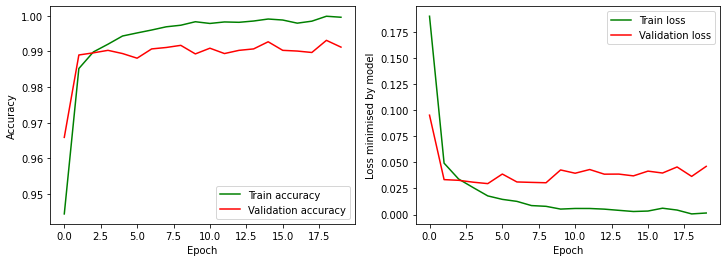

In [11]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(X_train, y_train, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(X_val, y_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

## Final model and analysis

Once you are happy with how your model performs on the validation set, it is time to re-train it on the original training set (i.e., including the validation set). This means that you no longer have a validation set to use during training. So you only have to execute the following steps once you are satisfied with the model you created!

Once this re-training has been done, you can analyse how your network performs on the test set.



In [12]:
model_for_test = initial_model()
model_for_test.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 128
epochs = 50

history_for_test = model_for_test.fit(X_train_all, y_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               409728    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

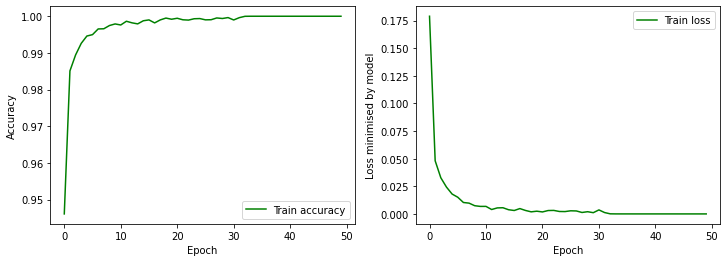

In [13]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

Finally we calculate the predictive accuracy of the model. 

In [14]:
[train_loss, train_accuracy] = model_for_test.evaluate(X_train_all, y_train_all, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[test_loss, test_accuracy] = model_for_test.evaluate(X_test, y_test, verbose=0)
print("Test set Accuracy:{:7.2f}".format(test_accuracy))
print("Test set Loss:{:7.4f}\n".format(test_loss))



Training set Accuracy:   1.00
Training set Loss: 0.0000

Test set Accuracy:   0.99
Test set Loss: 0.0519



## Evaluation

Finally, we visualize some incorrectly predicted digits.

In [15]:
predictions = model_for_test.predict(X_test)
# The first digit should be a 7 (shown as 1. at index 7)
print(y_test[0])

# Check the probabilities returned by predict for first test sample
# The function enumerate() receives and iterable and creates an iterator that, for each element, 
# returns a tuple containing the element's index and value
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')
    
# Our model believes this digit is a 7 with nearly 100% certainty
# Not all predictions have this level of certainty

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0: 0.0000000000%
1: 0.0000000000%
2: 0.0000000000%
3: 0.0000000000%
4: 0.0000000000%
5: 0.0000000000%
6: 0.0000000000%
7: 100.0000000000%
8: 0.0000000000%
9: 0.0000000000%


In the following snippet, p is the predicted value array, and e is the expected value array
NumPy’s argmax() function determines then index of an array’s highest valued element
Python's built-in zip function enables you to iterate over multiple iterables of data at the same time. The function receives as arguments any number of iterables and returns an iterator that produces tuples containing the elements at the same index in each.

In [16]:
# Locating the Incorrect Predictions
images = X_test.reshape((10000, 28, 28))

incorrect_predicted_images = []
predicted_digits = []
expected_digits = []

for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)

    if predicted != expected:  # prediction was incorrect
        incorrect_predicted_images.append(images[i])
        predicted_digits.append(predicted)
        expected_digits.append(expected)

<Figure size 432x288 with 0 Axes>

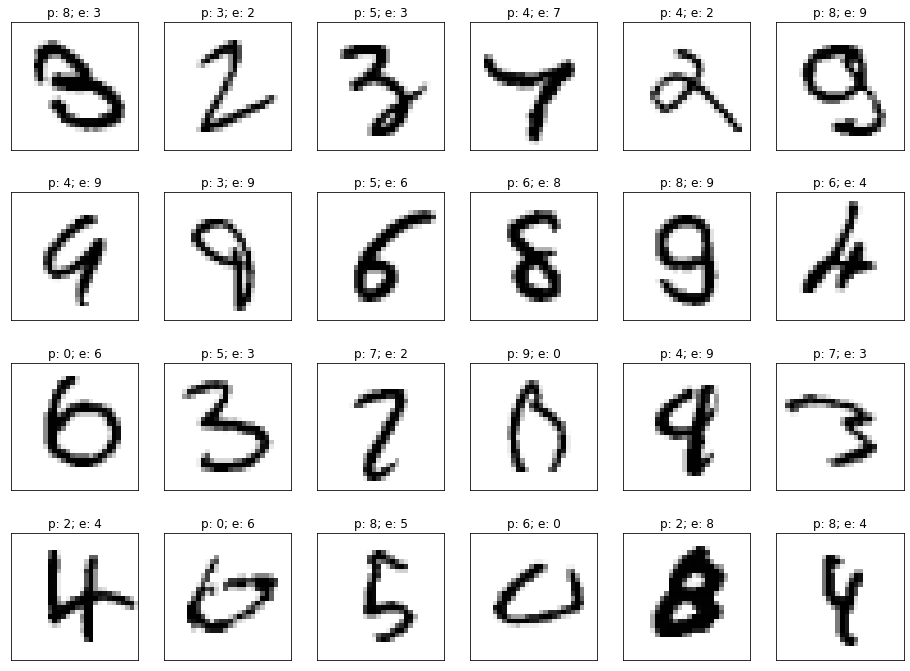

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure()
nrows,ncols=4,6
plt.subplots(nrows,ncols, figsize=(16, 12))

for i in range(nrows*ncols):  # show first 24 digits
  plt.subplot(nrows,ncols,i+1)  # i+1 is position of subplot in nrows x ncols table
  # show bitmap, interpret 0 as white and 255 as black (grayvalues)
  plt.imshow(incorrect_predicted_images[i].reshape(28,28), cmap=plt.cm.gray_r)
  plt.title(f'p: {predicted_digits[i]}; e: {expected_digits[i]}')
  plt.xticks([])   # no ticks on x axis
  plt.yticks([])   # not ticks on y axis